In [55]:
import sys
# Add the ptdraft folder path to the sys.path list
sys.path.append('../Augmentor/')
# sys.path.append('../generate_license_plates-master/')

In [56]:
# from generate import generateNumber
import Augmentor
import cv2
import numpy as np

In [57]:
import os
import itertools
import codecs
import re
import datetime
import Augmentor
import cv2
import numpy as np
import editdistance
import numpy as np
import glob
from scipy import ndimage
import pylab
from PIL import ImageFont, ImageDraw, Image
from keras import backend as K
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers import Input, Dense, Activation, Dropout
from keras.layers import Reshape, Lambda
from keras.layers.merge import add, concatenate
from keras.models import Model
from keras.layers.recurrent import GRU
from keras.optimizers import SGD, Adam
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.models import load_model
import keras.callbacks
import random as rd
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session

In [58]:
# character classes and matching regex filter
regex = r'^[ 0-9A-Za-zА-Яа-яЁё&\/\\.()\-,#;:\'°@_[\]<>"]+$№«»?!—|“”'
alphabet = u' 0123456789AaBbCcDdEeFfGgHhIiJjKkLlMmNnOoPpQqRrSsTtUuVvWwXxYyZz'\
'АаБбВвГгДдЕеЁёЖжЗзИиЙйКкЛлМмНнОоПпРрСсТтУуФфХхЦцЧчШшЩщЪъЫыЬьЭэЮюЯя'\
'&\/.()-,#;:\'°@_[]<>"]+$№«»?!—|“”'

In [59]:
MAX_CHARACHTERS_IN_LINE = 100

Функция перевода текста в индексы

In [60]:
# Translation of characters to unique integer values
def text_to_labels(text):
    ret = []
    if(len(text) > MAX_CHARACHTERS_IN_LINE):
        print("text > {}".format(MAX_CHARACHTERS_IN_LINE), text)  
    for char in text:
        ch = alphabet.find(char)
        if(ch == -1):
            print("text_to_labels char '{}' not found in text: {}".format(char, text))
        else:    
            ret.append(ch)
    
    return ret

Функция перевода индексов в тексты

In [61]:
def labels_to_text(labels):
    ret = []
    for c in labels:
        if c != len(alphabet):  # CTC Blank
            ret.append(alphabet[c])
    return "".join(ret)

Проверка того что наши тексты содержат только нужные нам символы

In [62]:
def is_valid_str(in_str):
    search = re.compile(regex, re.UNICODE).search
    return bool(search(in_str))

СТС функция

In [63]:
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage:
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

Функция декодирования бача, нужна для тестирования

In [64]:
def decode_batch(test_func, word_batch):
    out = test_func([word_batch])[0]
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = labels_to_text(out_best)
        ret.append(outstr)
    return ret

In [65]:
def load_dict(filename):
    with open(filename) as f:
        data = f.readlines()
        data = [d[:98].strip() for d in data]
        
#         a=  [text_to_labels(d) for d in data]
#         print("data len:", str(len(data)))
#         print(a)
    return data

In [66]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import random as rd
%matplotlib inline

Генератор бачей

In [90]:
class TextImageGenerator(keras.callbacks.Callback):
    
    def __init__(self, 
                 samples, 
                 img_w, img_h, 
                 batch_size, 
                 downsample_factor,
                 max_text_len=100,
                 gen_samples_len=500):

        photos = load_dict("./data/results.txt")
#         dict_words = load_dict("./data/words_dict.txt")
#         dict_words = rd.sample(dict_words, 5000)
#         bank_name = load_dict("./data/banksName.txt")
#         bank_bik = load_dict("./data/banksBik.txt")
#         bank_acc = load_dict("./data/banksCorrAcc.txt")
#         receiver_name = load_dict("./data/firmsNames.txt")
#         other_words = ["Получатель", "Банк получателя", "БИК", "Сч. №", "ИНН", "КПП"]*100
        
        self.samples = samples + photos#+ bank_name + bank_bik + bank_acc + receiver_name + other_words + dict_words
        self.img_h = img_h
        self.img_w = img_w
        self.batch_size = batch_size
        self.max_text_len = max_text_len
        self.downsample_factor = downsample_factor
        
        self.kernel_sharpen = np.array([[0,-1,0], [-1,5,-1], [0,-1,0]])
        self.kernel_gaussian_blur = np.array([[1,2,1], [2,4,2], [1,2,1]]) / 16
#         print(self.samples[:10])   
        
        self.n = len(self.samples) + gen_samples_len
        self.indexes = list(range(self.n))
        rd.shuffle(self.indexes)
        self.cur_index = 0
        self.augment_pipline = self.aug(img_w, img_h)
        
    def generate_image(self, text, font_size=20):
        # Create a black image
        H = self.img_h
        W = self.img_w
        back = rd.randint(0, 250)
        img = np.full((H,W,3), back, np.uint8)
        
        fonts = ["./fonts/Arial.ttf","./fonts/Arial.ttf","./fonts/Arial.ttf",
                 "./fonts/Arial.ttf","./fonts/Arial.ttf","./fonts/Arial.ttf",
                 "./fonts/Arial.ttf","./fonts/Arial.ttf","./fonts/Arial Black.ttf", "./fonts/Arial Bold.ttf" ]
        font_type = rd.choice(fonts)
        font_size = rd.randint(30,60)
        font_color = rd.randint(0,60)
        fontColor = (font_color,0,0,0)

        img_pil = Image.fromarray(img)
        draw = ImageDraw.Draw(img_pil)

        font = ImageFont.truetype(font_type, font_size)
        w, h = draw.textsize(text, font = font)

        while w > W or h > H:
            font_size -= 3
            font = ImageFont.truetype(font_type, font_size)
            w, h = draw.textsize(text, font = font)

        x = rd.randint(0, max(W-w-1, 0))
        y = 0 #rd.randint(0, max(H-h-1, 0))
        draw.text((x,y), text, font = font, fill = fontColor)
        img = np.array(img_pil, dtype=np.uint8)[:,:,0]

        return img    
    
    def build_data(self, index):
        is_text = index < len(self.samples)
        is_photo = index < len(self.samples) and "\t" in self.samples[index]
#         print("index", index, is_photo)
        if is_photo:
            split = self.samples[index].split("\t")
            img_filepath = "./data/images/"+split[0]
#             print(img_filepath)
            text = split[1]
            img = cv2.imread(img_filepath, 0)
            img = self.resize(img, self.img_w, self.img_h)
            img = np.array(img.astype(np.ubyte))
        elif is_text:
            text = self.samples[index]
            img = self.generate_image(text)
        else:
            diff_data_count = 3
            receiver_inn = index % diff_data_count == 0
            receiver_kpp = index % diff_data_count == 1        
            receiver_acc = index % diff_data_count == 2
            
            if receiver_inn: img, text = self.generate_receiver_inn()
            elif receiver_kpp: img, text = self.generate_receiver_kpp()
            else : img, text = self.generate_receiver_acc()
        
        if not is_photo:
            text_len = len(text)
            height = int(self.max_text_len / (text_len / 20))
            img = cv2.resize(img, (self.img_w, self.img_h * 2)) [:height, :]


            img = self.speckle(img, 30)
            img = cv2.filter2D(img, -1, self.kernel_gaussian_blur)
            img = self.sp_noise(img,3)
            img = cv2.filter2D(img, -3, self.kernel_sharpen)
            img = cv2.resize(img, (300,36))
            img = cv2.resize(img, (self.img_w, self.img_h))
            img = self.sp_noise(img,10)

        img = np.asarray(self.augment_pipline._execute_with_array(img))
        plt.imshow(img, cmap='gray')   
        img = img.astype(np.float32)
        img /= 255
        return img, text
        
    def get_output_size(self):
        return len(alphabet) + 1
    
    def next_sample(self):
        self.cur_index += 1
        if self.cur_index >= self.n:
            self.cur_index = 0
            rd.shuffle(self.indexes)
            
        return self.build_data(self.indexes[self.cur_index])
#         return self.imgs[self.indexes[self.cur_index]], self.texts[self.indexes[self.cur_index]]
    
    def next_batch(self):
        while True:
            X_data = np.zeros([self.batch_size, self.img_w, self.img_h, 1])
            Y_data = np.zeros([self.batch_size, self.max_text_len])
            input_length = np.ones((self.batch_size, 1)) * (self.img_w // self.downsample_factor - 2)
            label_length = np.zeros((self.batch_size, 1))
            source_str = []
                                   
            for i in range(self.batch_size):
                img, text = self.next_sample()
                img = img.T
                img = np.expand_dims(img, -1)
                X_data[i] = img
                labels = text_to_labels(text)
                Y_data[i,  0:len(labels)] = labels
                source_str.append(text)
                label_length[i] = len(text)
                
            inputs = {
                'the_input': X_data,
                'the_labels': Y_data,
                'input_length': input_length,
                'label_length': label_length,
                #'source_str': source_str
            }
            outputs = {'ctc': np.zeros([self.batch_size])}
#             print(self.cur_index)
            yield (inputs, outputs)
            
    def on_epoch_begin(self, epoch, logs={}):
        # rebind the paint function to implement curriculum learning
        # if 3 <= epoch < 6:
        print("on_epoch_begin")
        
    def aug(self, w,h):
        p = Augmentor.Pipeline()
#         width = int(w*1.7)
#         height = int(h*1.7)
        p.zoom(probability=1, min_factor=0.95, max_factor=1)
        p.skew_tilt(probability=0.2,magnitude=0.05)
        p.rotate(probability=0.2, max_left_rotation=0.5, max_right_rotation=0.5)
        p.shear(probability=0.2, max_shear_left=0.5, max_shear_right=0.5)
        
#         width = int(w//2)
#         height = int(h//2)
#         p.random_distortion(0.25, grid_width=width, grid_height=height, magnitude=1)

#         width = w//1
#         height = h//1
#         p.random_distortion(0.25, grid_width=width, grid_height=height, magnitude=1)
      

        return p    
    
    def speckle(self, img, maximum):
        severity = np.random.uniform(0, 1) * maximum
        blur = ndimage.gaussian_filter(np.random.randn(*img.shape) * severity, 4, truncate=10)
        img_speck = (img + (blur/5))
        img_speck[img_speck > 255] = 255
        img_speck[img_speck <= 0] = 0
        img_speck = np.array(img_speck.astype(np.ubyte))
        return img_speck
    
    def sp_noise(self, img, maximum):
        blur = np.random.rand(*img.shape) * maximum
        img_speck = img + blur
        img_speck[img_speck > 255] = 255
        img_speck[img_speck <= 0] = 0
        img_speck = np.array(img_speck.astype(np.ubyte))
        return img_speck

    def saturate(self, image, min_sat, max_sat):
        severity = np.random.uniform(min_sat, max_sat)
        img_speck = (image + severity)
        img_speck[img_speck > 255] = 255
        img_speck[img_speck <= 0] = 0
        img_speck = np.array(img_speck.astype(np.int32))
        return img_speck
   
    def generate_receiver_inn(self):
        num_inn = rd.randint(0, 9999999999)
        text = "{:010d}".format(num_inn)
        img = self.generate_image(text)
        return img, text
    def generate_receiver_kpp(self):
        num_kpp = rd.randint(0, 999999999)
        text = "{:09d}".format(num_kpp)
        img = self.generate_image(text)
        return img, text
    def generate_receiver_acc(self):
        num_acc = rd.randint(0, 9999999999999999999)
        text = "4{:019d}".format(num_acc)
        img = self.generate_image(text)
        return img, text
    
    def resize(self, img, w, h ):
        inWidth = img.shape[1]
        inHeight = img.shape[0]
        dstWidth = w
        dstHeight = h
        scaleFactorX = dstWidth / inWidth;
        scaleFactorY = dstHeight / inHeight;

#         if (dstWidth > inWidth):
#             scaleFactor = max(scaleFactorX, scaleFactorY);
#         else:
        scaleFactor = min(scaleFactorX, scaleFactorY);

        newW = int(inWidth * scaleFactor)    
        newH = int(inHeight * scaleFactor)
        y = int((dstHeight - newH)/2)

        img_new = np.full((48,400), 220)
        img_new[y:(newH+y),:newW] = cv2.resize(img, ( newW, newH))[:,:]
        return img_new

In [91]:
img_gen = TextImageGenerator(samples=[],
                                 img_w=400,
                                 img_h=48,
                                 batch_size=32,
                                 downsample_factor=1,
                                 gen_samples_len=100)

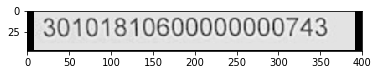

In [92]:
img = img_gen.build_data(2)#rd.randint(0, 10000))

Класс отрисовки результата

In [93]:
class VizCallback(keras.callbacks.Callback):

    def __init__(self, output_dir, run_name, test_func, text_img_gen, num_display_words=6):
        self.test_func = test_func
        self.output_dir = os.path.join(
            output_dir, run_name)
        self.text_img_gen = text_img_gen
        self.num_display_words = num_display_words
        if not os.path.exists(self.output_dir):
            os.makedirs(self.output_dir)

    def show_edit_distance(self, num):
        num_left = num
        mean_norm_ed = 0.0
        mean_ed = 0.0
        while num_left > 0:
            word_batch = next(self.text_img_gen)[0]
            num_proc = min(word_batch['the_input'].shape[0], num_left)
            decoded_res = decode_batch(self.test_func, word_batch['the_input'][0:num_proc])
            for j in range(num_proc):
                edit_dist = editdistance.eval(decoded_res[j], labels_to_text(word_batch['the_labels'][j].astype(np.int32)))
                mean_ed += float(edit_dist)
                mean_norm_ed += float(edit_dist) / len(word_batch['the_labels'][j])
            num_left -= num_proc
        mean_norm_ed = mean_norm_ed / num
        mean_ed = mean_ed / num
        print('\nOut of %d samples:  Mean edit distance: %.3f Mean normalized edit distance: %0.3f'
              % (num, mean_ed, mean_norm_ed))

    def on_epoch_end(self, epoch, logs={}):
        self.model.save_weights(os.path.join(self.output_dir, 'weights%02d.h5' % (epoch)))
        self.show_edit_distance(350)
        word_batch = next(self.text_img_gen)[0]
        res = decode_batch(self.test_func, word_batch['the_input'][0:self.num_display_words])
        if word_batch['the_input'][0].shape[0] < 350:
            cols = 2
        else:
            cols = 1
        for i in range(self.num_display_words):
            pylab.subplot(self.num_display_words // cols, cols, i + 1)
            
            the_input = word_batch['the_input'][i, :, :, 0]
            pylab.imshow(the_input.T, cmap='Greys_r')
            pylab.xlabel('Truth = \'%s\'\nDecoded = \'%s\'' % (labels_to_text(word_batch['the_labels'][i].astype(np.int32)), res[i]))
        fig = pylab.gcf()
        fig.set_size_inches(10, 13)
        pylab.savefig(os.path.join(self.output_dir, 'e%02d.png' % (epoch)))
        pylab.close()

Функция взятия номера из названия файла фото

Функция тренировки

In [94]:
def train(run_name, start_epoch, stop_epoch, img_w = 128, img_h = 64):

#
    K.set_learning_phase(1)
    images = [] #[-100:]
  
    # Input Parameters
   
    gen_samples_len = 500  

    # Network parameters
    conv_filters = 16
    kernel_size = (3, 3)
    pool_size = 2
    time_dense_size = 128
    rnn_size = 256 #512
    minibatch_size = 32
    
#     images = images[: len(images) - (len(images) % minibatch_size)]
#     rd.shuffle(images)
#     words_per_epoch = len(images)
    val_split = 0.2
    val_words = int(((len(images) + gen_samples_len) * val_split) - \
                    (((len(images) + gen_samples_len) * val_split) % minibatch_size))#int(round(words_per_epoch * (val_split)))
    print("len train",len(images))
    print("len val",val_words)
    input_shape = (img_w, img_h, 1)

    
    max_pool_layers = 2
    

    img_gen = TextImageGenerator(samples=images,
                                 img_w=img_w,
                                 img_h=img_h,
                                 batch_size=minibatch_size,
                                 downsample_factor=(pool_size ** max_pool_layers),
                                 gen_samples_len=gen_samples_len)
#     img_gen.build_data()
    
    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
#     inner = Conv2D(conv_filters, kernel_size, padding='same',
#                    activation=act, kernel_initializer='he_normal',
#                    name='conv0')(input_data)
#     inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max0')(input_data)
    inner = Conv2D(conv_filters*2, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters*3, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)
   
    print("inner.shape", inner.shape)
    conv_to_rnn_dims = (img_w // (pool_size ** max_pool_layers), (img_h // (pool_size ** max_pool_layers)) * conv_filters*3)
    print("conv_to_rnn_dims", conv_to_rnn_dims)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    # cuts down input size going into RNN:
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

    # Two layers of bidirectional GRUs
    # GRU seems to work as well, if not better than LSTM:
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

    # transforms RNN output to character activations:
    inner = Dense(img_gen.get_output_size(), kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)
    # Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[img_gen.max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int32')
    label_length = Input(name='label_length', shape=[1], dtype='int32')
    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    print("y_pred: {}\nlabels: {}\ninput_length: {}\nlabel_length: {}".format(y_pred, labels, input_length, label_length))
    # print("max(labels.indices(labels.indices[:, 1] == b, 2))", max(labels.indices()))
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    # clipnorm seems to speeds up convergence
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    # adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

    model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    model.summary()
    if start_epoch > 0:
        weight_file = os.path.join(os.path.join("output",run_name), 'weights%02d.h5' % (start_epoch - 1))
        model.load_weights(weight_file)
    # captures output of softmax so we can decode the output during visualization
    test_func = K.function([input_data], [y_pred])

    viz_cb = VizCallback("output", run_name, test_func, img_gen.next_batch())
#     model.save("model_data/model.h5")
    model.fit_generator(generator=img_gen.next_batch(),
                        steps_per_epoch=img_gen.n // minibatch_size,
                        epochs=stop_epoch,
                        validation_data=img_gen.next_batch(),
                        validation_steps=val_words // minibatch_size,
                        callbacks=[viz_cb, img_gen],
                        initial_epoch=start_epoch)

Тренировка

In [116]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.3
set_session(tf.Session(config=config))
run_name = "train" #datetime.datetime.now().strftime('%Y:%m:%d:%H:%M:%S')
train(run_name, 120, 150, img_w = 400, img_h = 48)
# increase to wider images and start at epoch 20. The learned weights are reloaded
# train(run_name, 20, 25)

len train 0
len val 96
inner.shape (?, 100, 12, 48)
conv_to_rnn_dims (100, 576)
y_pred: Tensor("softmax_18/truediv:0", shape=(?, 100, 162), dtype=float32)
labels: Tensor("the_labels_18:0", shape=(?, 100), dtype=float32)
input_length: Tensor("input_length_18:0", shape=(?, 1), dtype=int32)
label_length: Tensor("label_length_18:0", shape=(?, 1), dtype=int32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 400, 48, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 400, 48, 32)  320         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 200, 24, 

78/78 [==============================] - 66s 847ms/step - loss: 3.6277 - val_loss: 3.9800

Out of 350 samples:  Mean edit distance: 84.597 Mean normalized edit distance: 0.846
Epoch 137/150
on_epoch_begin
78/78 [==============================] - 66s 841ms/step - loss: 3.4001 - val_loss: 3.9072

Out of 350 samples:  Mean edit distance: 84.814 Mean normalized edit distance: 0.848
Epoch 138/150
on_epoch_begin
78/78 [==============================] - 62s 798ms/step - loss: 3.6279 - val_loss: 3.5515

Out of 350 samples:  Mean edit distance: 85.057 Mean normalized edit distance: 0.851
Epoch 139/150
on_epoch_begin
78/78 [==============================] - 63s 811ms/step - loss: 3.6037 - val_loss: 4.6948

Out of 350 samples:  Mean edit distance: 85.249 Mean normalized edit distance: 0.852
Epoch 140/150
on_epoch_begin
78/78 [==============================] - 62s 801ms/step - loss: 3.8116 - val_loss: 4.7848

Out of 350 samples:  Mean edit distance: 84.409 Mean normalized edit distance: 0.844
Epoc

## Проверяем результат оставив только реальные фото

In [105]:
def decode_batch_test(out):
    ret = []
    for j in range(out.shape[0]):
        out_best = list(np.argmax(out[j, 2:], 1))
        out_best = [k for k, g in itertools.groupby(out_best)]
        outstr = ''
        for c in out_best:
            if c < len(alphabet):
                outstr += alphabet[c]
        ret.append(outstr)
    return ret

In [106]:
def get_model(run_name, start_epoch, img_w = 400, img_h = 48, gen_samples_len = 10000):


    K.set_learning_phase(0)
    fdir = os.path.expanduser(os.path.join('train/'))
    images = [] #get_images(fdir)
  
    # Input Parameters
   
    # Network parameters
    conv_filters = 16
    kernel_size = (3, 3)
    pool_size = 2
    time_dense_size = 128
    rnn_size = 256
    minibatch_size = 32
    
    images = images[: len(images) - (len(images) % minibatch_size)]
    rd.shuffle(images)
    words_per_epoch = len(images)
    val_split = 0.2
    val_words = int(((len(images) + gen_samples_len) * val_split) - \
                    (((len(images) + gen_samples_len) * val_split) % minibatch_size))#int(round(words_per_epoch * (val_split)))
    print("len train",len(images))
    print("len val",val_words)
    input_shape = (img_w, img_h, 1)

    
    max_pool_layers = 2
    

    img_gen = TextImageGenerator(samples=images,
                                 img_w=img_w,
                                 img_h=img_h,
                                 batch_size=minibatch_size,
                                 downsample_factor=(pool_size ** max_pool_layers),
                                 gen_samples_len=gen_samples_len)
#     img_gen.build_data()
    
    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
#     inner = Conv2D(conv_filters, kernel_size, padding='same',
#                    activation=act, kernel_initializer='he_normal',
#                    name='conv0')(input_data)
#     inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max0')(inner)
    inner = Conv2D(conv_filters*2, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters*3, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)
   
    print("inner.shape", inner.shape)
    conv_to_rnn_dims = (img_w // (pool_size ** max_pool_layers), (img_h // (pool_size ** max_pool_layers)) * conv_filters*3 )
    print("conv_to_rnn_dims", conv_to_rnn_dims)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    # cuts down input size going into RNN:
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

    # Two layers of bidirectional GRUs
    # GRU seems to work as well, if not better than LSTM:
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

    # transforms RNN output to character activations:
    inner = Dense(img_gen.get_output_size(), kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)
    # Model(inputs=input_data, outputs=y_pred).summary()

    labels = Input(name='the_labels', shape=[img_gen.max_text_len], dtype='float32')
    input_length = Input(name='input_length', shape=[1], dtype='int32')
    label_length = Input(name='label_length', shape=[1], dtype='int32')
    # Keras doesn't currently support loss funcs with extra parameters
    # so CTC loss is implemented in a lambda layer
    print("y_pred: {}\nlabels: {}\ninput_length: {}\nlabel_length: {}".format(y_pred, labels, input_length, label_length))
    # print("max(labels.indices(labels.indices[:, 1] == b, 2))", max(labels.indices()))
    loss_out = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])

    # clipnorm seems to speeds up convergence
    sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)
    # adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-8)

    model = Model(inputs=[input_data, labels, input_length, label_length], outputs=loss_out)

    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    model.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=sgd)
    model.summary()
    
    weight_file = os.path.join(os.path.join("output",run_name), 'weights%02d.h5' % (start_epoch))
    print(weight_file)
    model.load_weights(weight_file)
    return model, img_gen

len train 0
len val 0
inner.shape (?, 100, 12, 48)
conv_to_rnn_dims (100, 576)
y_pred: Tensor("softmax_22/truediv:0", shape=(?, 100, 162), dtype=float32)
labels: Tensor("the_labels_22:0", shape=(?, 100), dtype=float32)
input_length: Tensor("input_length_22:0", shape=(?, 1), dtype=int32)
label_length: Tensor("label_length_22:0", shape=(?, 1), dtype=int32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 400, 48, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 400, 48, 32)  320         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 200, 24, 3

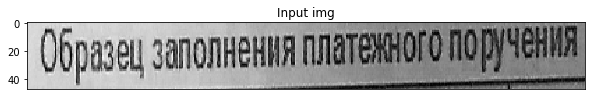

In [120]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline


model, data_test = get_model(run_name, 114, img_w = 400, img_h = 48, gen_samples_len=0)

net_inp = model.get_layer(name='the_input').input
net_out = model.get_layer(name='softmax').output

sess = K.get_session()

img = cv2.imread("./data/Gmail/3.jpg")[:,:,0] 
img = cv2.resize(img, (400,48))
img = img.astype(np.float32)
img /= 255
img = img.T
img = np.expand_dims(img, -1)    

inp_value = {}
inp_value['the_input'] = np.array([img])
inp_value['the_labels'] = [text_to_labels("Банк получателя")]

bs = inp_value['the_input'].shape[0]
X_data = inp_value['the_input']
net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
pred_texts = decode_batch_test(net_out_value)
labels = inp_value['the_labels']
texts = []
for label in labels:
    text = ''.join(list(map(lambda x: alphabet[int(x)], label)))
    texts.append(text)

for i in range(1):
    fig = plt.figure(figsize=(10, 10))
    outer = gridspec.GridSpec(1, 1, wspace=10, hspace=0.1)
    ax1 = plt.Subplot(fig, outer[0])
    fig.add_subplot(ax1)
    print('Predicted: %s' % (pred_texts[i]))
    img = X_data[i][:, :, 0].T
    ax1.set_title('Input img')
    ax1.imshow(img, cmap='gray')
    ax1.set_xticks([])
    plt.show()    

len train 0
len val 0
inner.shape (?, 100, 12, 48)
conv_to_rnn_dims (100, 576)
y_pred: Tensor("softmax_23/truediv:0", shape=(?, 100, 162), dtype=float32)
labels: Tensor("the_labels_23:0", shape=(?, 100), dtype=float32)
input_length: Tensor("input_length_23:0", shape=(?, 1), dtype=int32)
label_length: Tensor("label_length_23:0", shape=(?, 1), dtype=int32)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 400, 48, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 400, 48, 32)  320         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 200, 24, 3

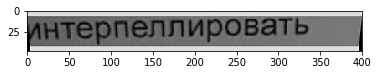

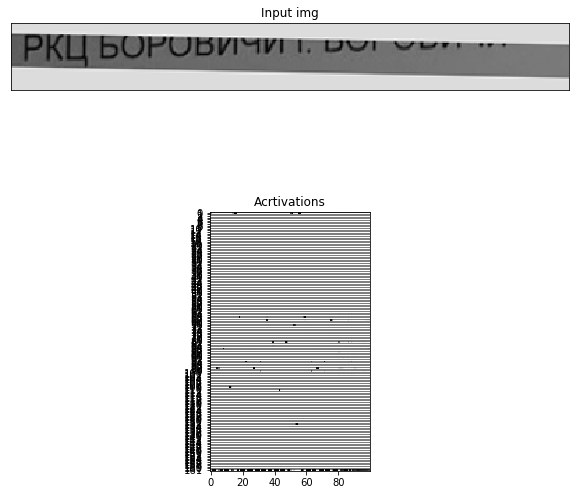

Predicted: 044030812
True: 044030812                                                                                           


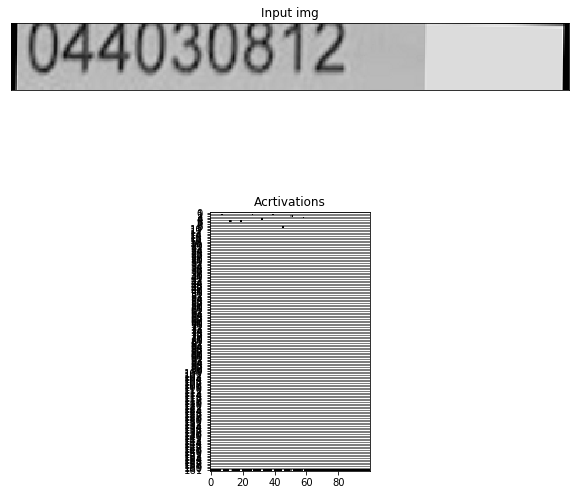

Predicted: 044080002
True: 044080002                                                                                           


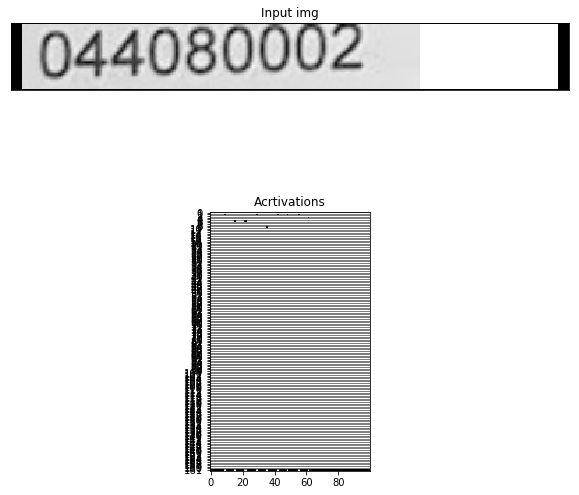

Predicted: очеса
True: очеса                                                                                               


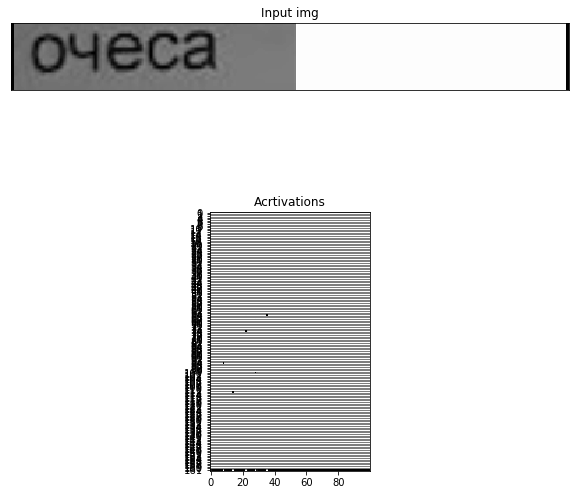

Predicted: долоножка
True: долгоножка                                                                                          


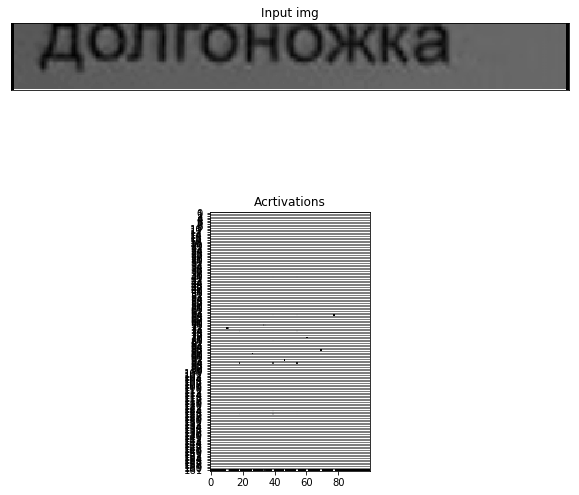

Predicted: КБ "НОВОЕ ВРЕМЯ" (ООО) г. МОСКВА
True: КБ "НОВОЕ ВРЕМЯ" (ООО) г. МОСКВА                                                                    


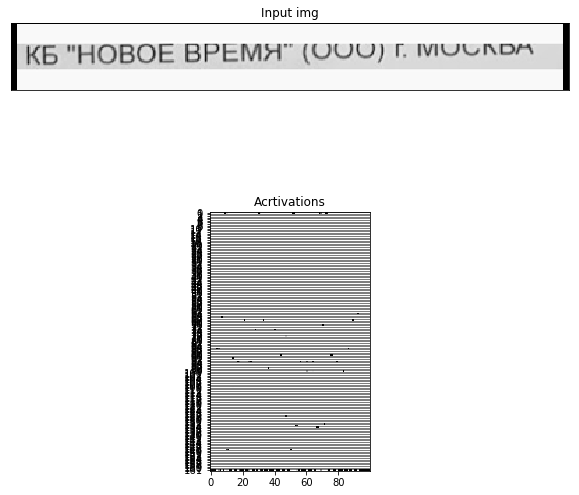

Predicted: ООО "Проло-МКзик"
True: ООО "Пролог-Мюзик"                                                                                  


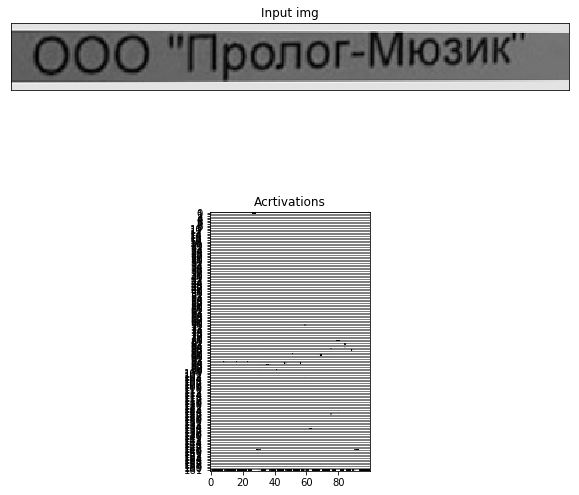

Predicted: проиндексированный
True: проиндексированный                                                                                  


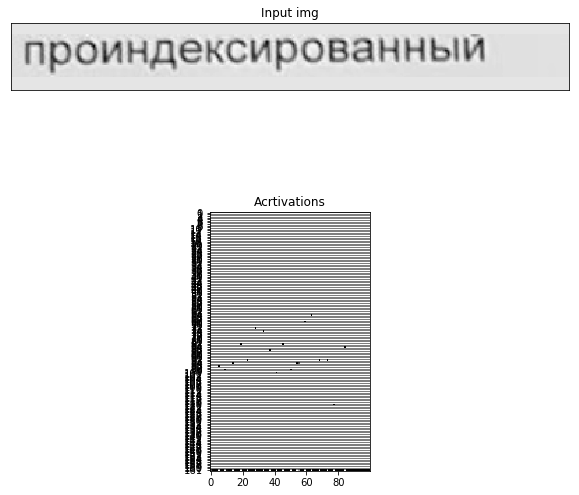

Predicted: АО КБ "ИВАНОВО" г. ИВАНОВО
True: АО КБ "ИВАНОВО" г. ИВАНОВО                                                                          


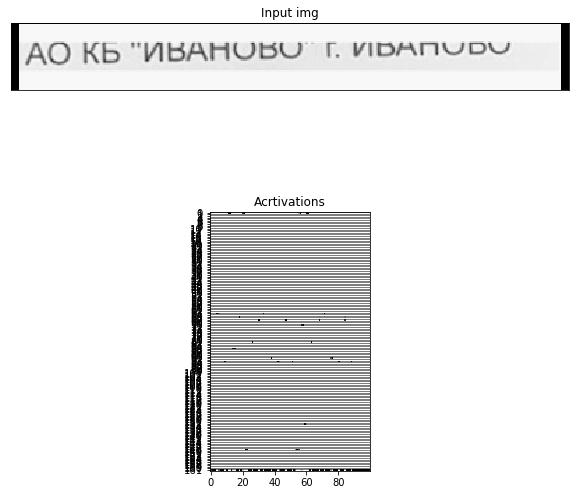

Predicted: 041501729
True: 041501729                                                                                           


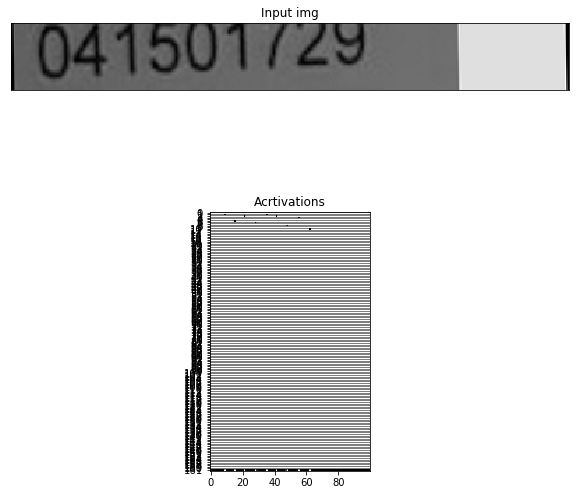

Predicted: Получатель
True: Получатель                                                                                          


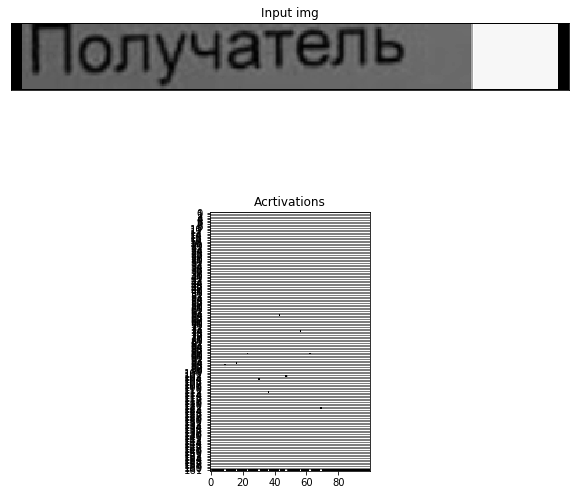

Predicted: 044525831
True: 044525831                                                                                           


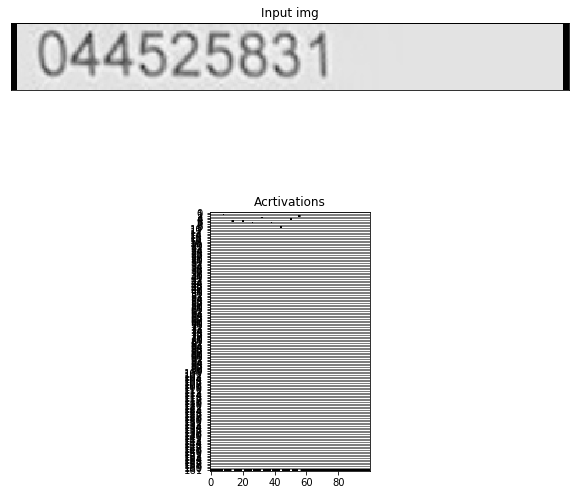

Predicted: аннона
True: аннона                                                                                              


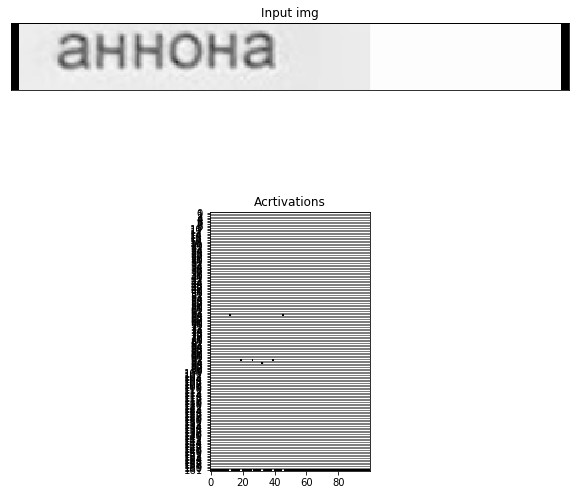

Predicted: лежать
True: лежать                                                                                              


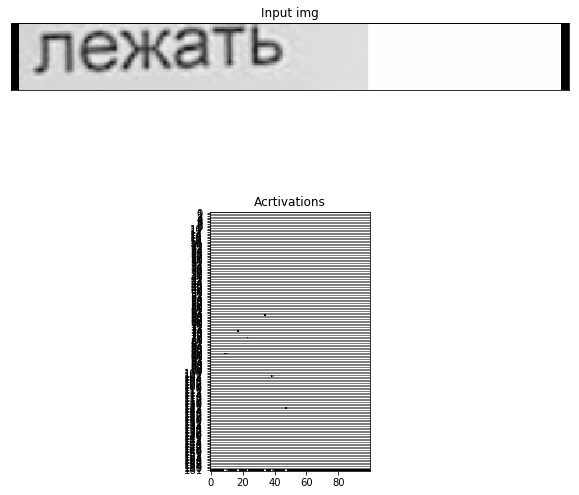

Predicted: высверливать
True: высверливать                                                                                        


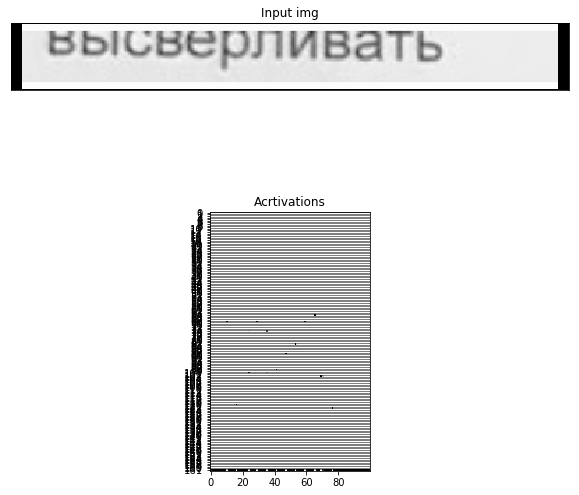

Predicted: ООО "Компания Нортекс"
True: ООО "Компания Нортекс"                                                                              


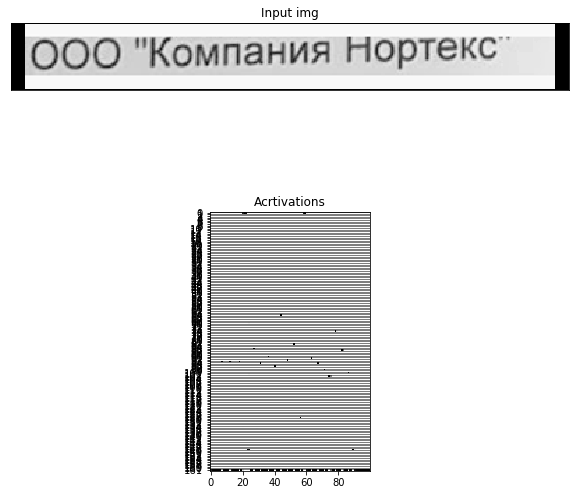

Predicted: четырёхугольный
True: четырёхугольный                                                                                     


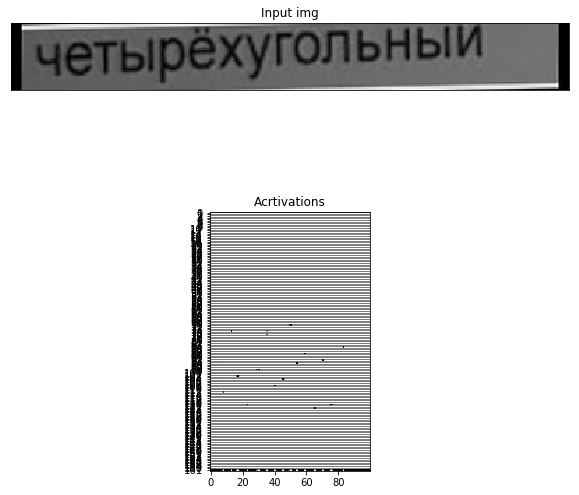

Predicted: ФИЛИАЛ N 2351 БАНКА ВТБ (.ПАО) г. КРАСНОДАР
True: ФИЛИАЛ N 2351 БАНКА ВТБ (ПАО) г. КРАСНОДАР                                                          


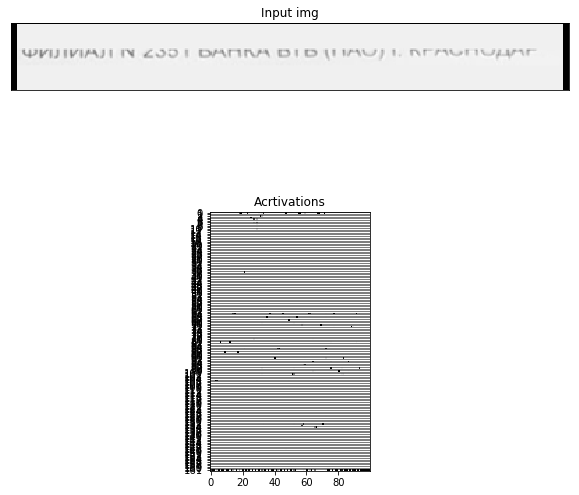

Predicted: ортодоксальный
True: ортодоксальный                                                                                      


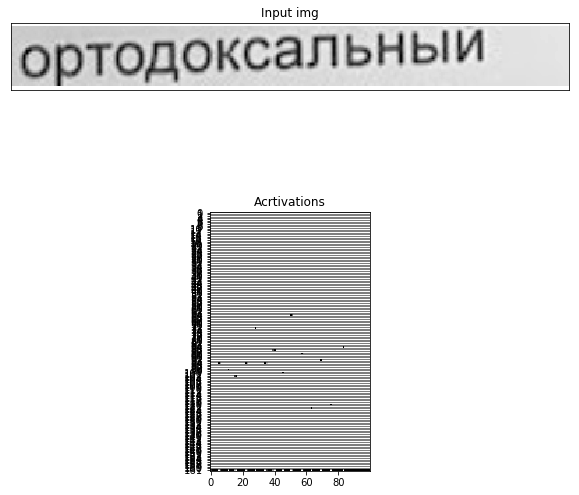

Predicted: 045209885
True: 045209885                                                                                           


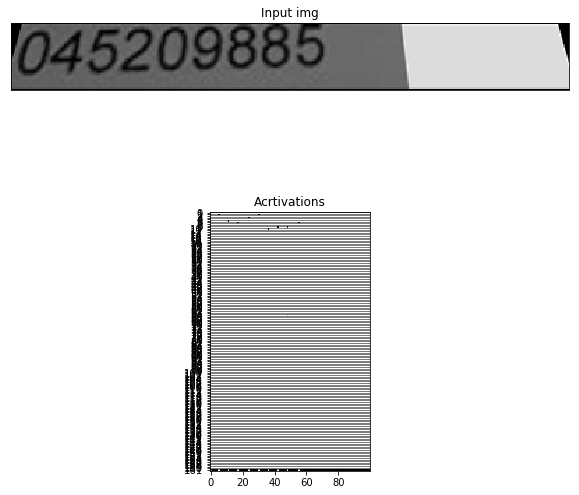

Predicted: бездомник
True: бездомник                                                                                           


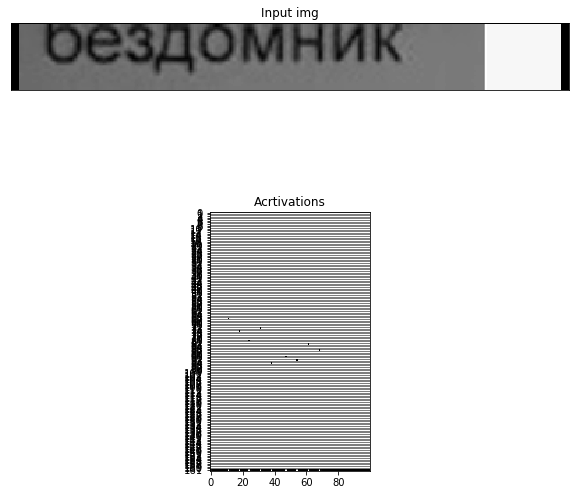

Predicted: клятвопреступница
True: клятвопреступница                                                                                   


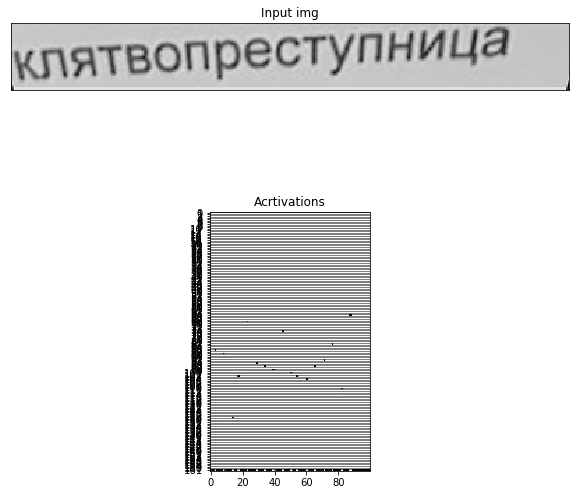

Predicted: ФИЛИАЛ АО "БАЙКАЛИНВЕСТБНК" В К. . СК
True: ФИЛИАЛ АО "БАЙКАЛИНВЕСТБАНК" В Г. МОСКВА г. МОСКВА                                                  


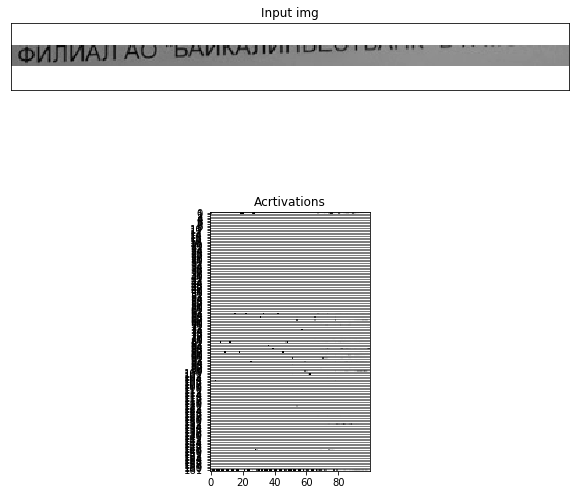

Predicted: Диатех-ЭМ, ООО
True: Диатех-ЭМ, ООО                                                                                      


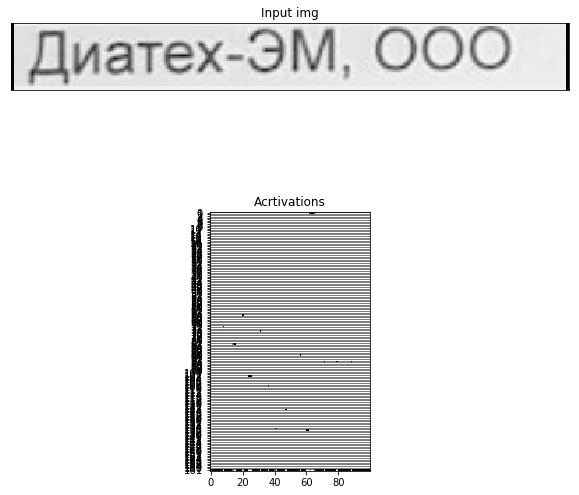

Predicted: воюющий
True: воюющий                                                                                             


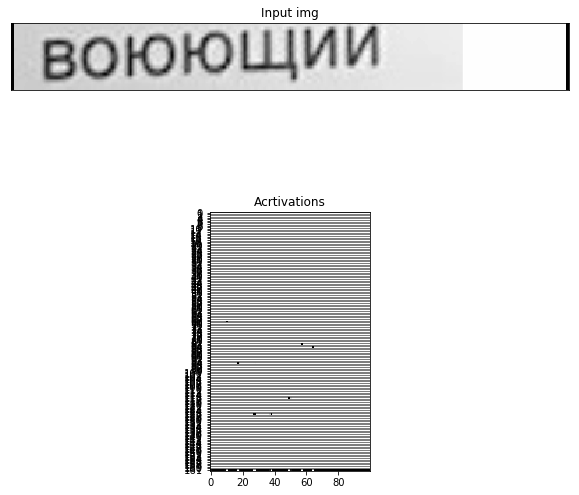

Predicted: ХАБАРОВСКИЙ ФИЛИАЛ НКО "ИНКАХРАН" (АО) г. ХАБАРОВСК
True: ХАБАРОВСКИЙ ФИЛИАЛ НКО "ИНКАХРАН" (АО) г. ХАБАРОВСК                                                 


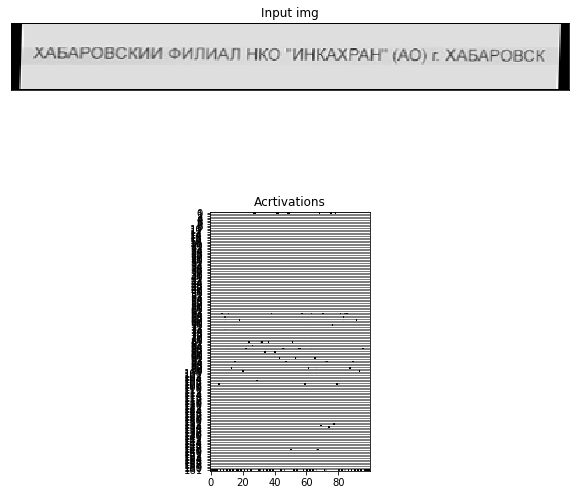

Predicted: надно-теоечекий
True: плодоовощевод                                                                                       


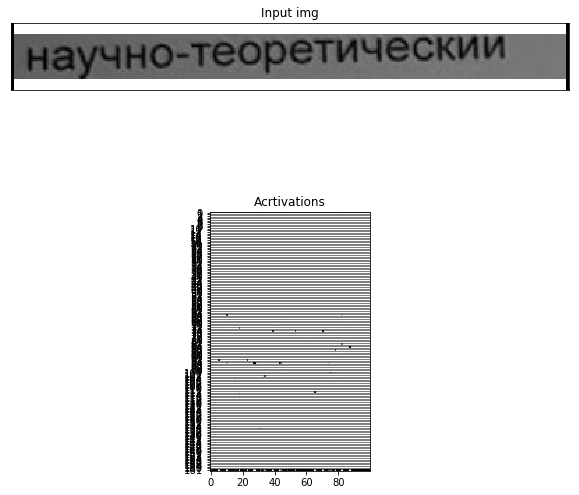

Predicted: брюшко
True: брюшко                                                                                              


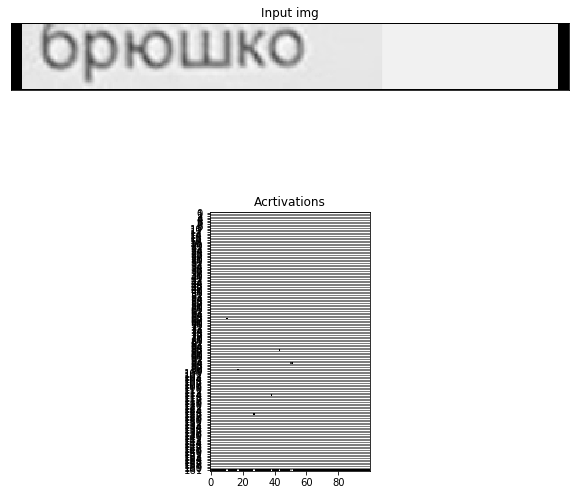

Predicted: ФПАО "ДАЛЬНЕВОСТОЧНЫЙ БАНК" ХАБА ОВСН Р г. САСВАСКВК
True: ФПАО "ДАЛЬНЕВОСТОЧНЫЙ БАНК" "ХАБАРОВСКИЙ" г. ХАБАРОВСК                                              


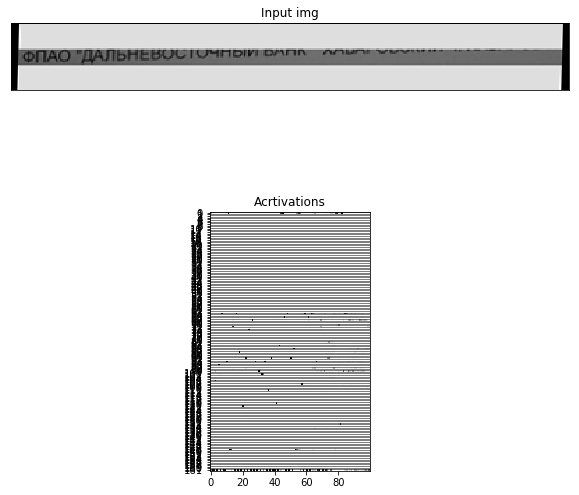

Predicted: бордюрчик
True: бордюрчик                                                                                           


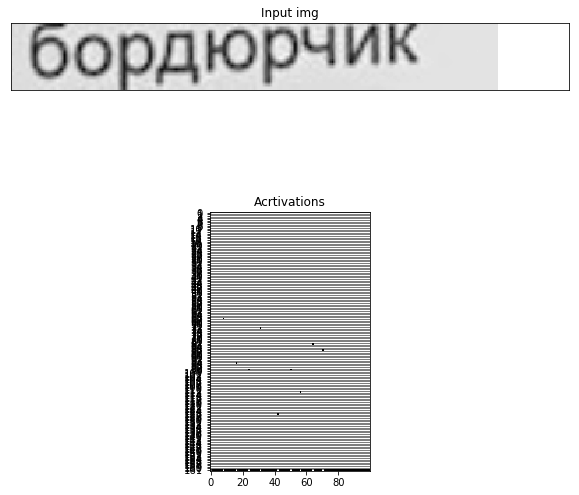

Predicted: ультрафильтрация
True: ультрафильтрация                                                                                    


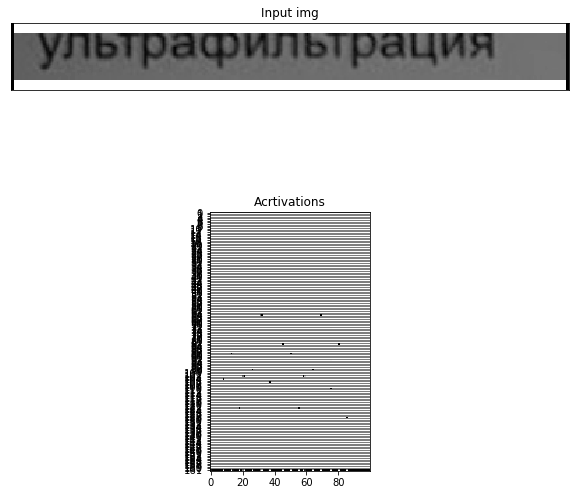

Predicted: интерпеллировать
True: интерпеллировать                                                                                    


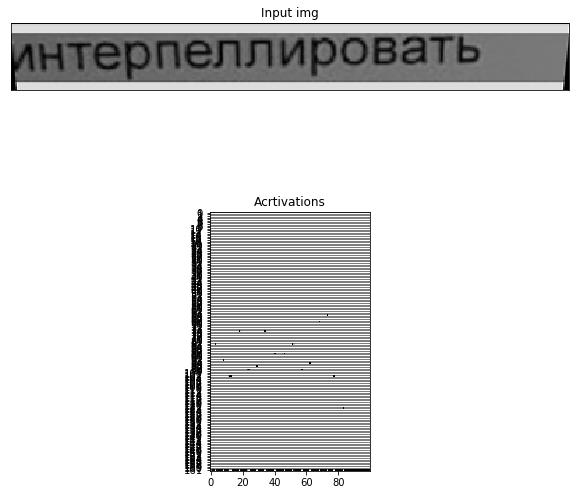

In [121]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline


model, data_test = get_model(run_name, 114, img_w = 400, img_h = 48, gen_samples_len=0)
# data_test.build_data()

net_inp = model.get_layer(name='the_input').input
net_out = model.get_layer(name='softmax').output

sess = K.get_session()
# index = 0
# for k, l in data_test.next_batch():
#     index += 1
#     if index == 5:
#         break
    
    
for inp_value, _ in data_test.next_batch():
    bs = inp_value['the_input'].shape[0]
    X_data = inp_value['the_input']
    net_out_value = sess.run(net_out, feed_dict={net_inp:X_data})
    pred_texts = decode_batch_test(net_out_value)
    labels = inp_value['the_labels']
    texts = []
    for label in labels:
        text = ''.join(list(map(lambda x: alphabet[int(x)], label)))
        texts.append(text)
    
    for i in range(bs):
        fig = plt.figure(figsize=(10, 10))
        outer = gridspec.GridSpec(2, 1, wspace=10, hspace=0.1)
        ax1 = plt.Subplot(fig, outer[0])
        fig.add_subplot(ax1)
        ax2 = plt.Subplot(fig, outer[1])
        fig.add_subplot(ax2)
        print('Predicted: %s\nTrue: %s' % (pred_texts[i], texts[i]))
        img = X_data[i][:, :, 0].T
        ax1.set_title('Input img')
        ax1.imshow(img, cmap='gray')
        ax1.set_xticks([])
        ax1.set_yticks([])
        ax2.set_title('Acrtivations')
        ax2.imshow(net_out_value[i].T, cmap='binary', interpolation='nearest')
        ax2.set_yticks(list(range(len(alphabet) + 1)))
#          pylab.xlabel('Truth = \'%s\'\nDecoded = \'%s\'' % (labels_to_text(word_batch['the_labels'][i].astype(np.int32)), res[i]))
#         ax2.set_yticklabels(labels_to_text(alphabet.astype(np.int32)) + ['blank'])
        ax2.grid(False)
        for h in np.arange(-0.5, len(alphabet) + 1 + 0.5, 1):
            ax2.axhline(h, linestyle='-', color='k', alpha=0.5, linewidth=1)
        
        #ax.axvline(x, linestyle='--', color='k')
        plt.show()
    break

## Подготовим данные к выгрузке в Андроид

Сохраним только нужную нам часть модели

In [122]:
def save_model():
    # Input Parameters
    img_h = 48
    img_w = 400
   

    # Network parameters
    conv_filters = 16
    kernel_size = (3, 3)
    pool_size = 2
    time_dense_size = 128
    rnn_size = 256
    minibatch_size = 32
    
    input_shape = (img_w, img_h, 1)

    
    max_pool_layers = 2
    

    act = 'relu'
    input_data = Input(name='the_input', shape=input_shape, dtype='float32')
#     inner = Conv2D(conv_filters, kernel_size, padding='same',
#                    activation=act, kernel_initializer='he_normal',
#                    name='conv0')(input_data)
#     inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max0')(inner)
    inner = Conv2D(conv_filters*2, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv1')(input_data)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max1')(inner)
    inner = Conv2D(conv_filters*3, kernel_size, padding='same',
                   activation=act, kernel_initializer='he_normal',
                   name='conv2')(inner)
    inner = MaxPooling2D(pool_size=(pool_size, pool_size), name='max2')(inner)
   
    print("inner.shape", inner.shape)
    conv_to_rnn_dims = (img_w // (pool_size ** max_pool_layers), (img_h // (pool_size ** max_pool_layers)) * conv_filters*3)
    print("conv_to_rnn_dims", conv_to_rnn_dims)
    inner = Reshape(target_shape=conv_to_rnn_dims, name='reshape')(inner)

    # cuts down input size going into RNN:
    inner = Dense(time_dense_size, activation=act, name='dense1')(inner)

    # Two layers of bidirectional GRUs
    # GRU seems to work as well, if not better than LSTM:
    gru_1 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru1')(inner)
    gru_1b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru1_b')(inner)
    gru1_merged = add([gru_1, gru_1b])
    gru_2 = GRU(rnn_size, return_sequences=True, kernel_initializer='he_normal', name='gru2')(gru1_merged)
    gru_2b = GRU(rnn_size, return_sequences=True, go_backwards=True, kernel_initializer='he_normal', name='gru2_b')(gru1_merged)

    # transforms RNN output to character activations:
    inner = Dense((len(alphabet) + 1), kernel_initializer='he_normal',
                  name='dense2')(concatenate([gru_2, gru_2b]))
    y_pred = Activation('softmax', name='softmax')(inner)

    model = Model(inputs=input_data, outputs=y_pred)
    model.summary()
    # the loss calc occurs elsewhere, so use a dummy lambda func for the loss
    # model.compile(loss={'softmax': lambda y_true, y_pred: y_pred}, optimizer="adam")
    model.save(os.path.join('model_data', 'model_finish.h5'))

    # sess = K.get_session()
    # export_base_path = 'tf-exports'
    # with open(os.path.join(export_base_path, "graph.pb"), "wb") as fout:
    #     fout.write(sess.graph.as_graph_def().SerializeToString())
    # print("Written graph.")

    return model

In [123]:
save_model()

inner.shape (?, 100, 12, 48)
conv_to_rnn_dims (100, 576)
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_input (InputLayer)          (None, 400, 48, 1)   0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 400, 48, 32)  320         the_input[0][0]                  
__________________________________________________________________________________________________
max1 (MaxPooling2D)             (None, 200, 24, 32)  0           conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 200, 24, 48)  13872       max1[0][0]                       
____________________________________________________

Выгрузим protobuf и checkpoint

In [124]:
def save_to_android(input_node_name, output_node_name):
    export_base_path = 'tf-exports'
    
    K.set_learning_phase(0)
    # model = simple_model2()
    model = load_model(os.path.join('model_data', 'model_finish.h5'), compile=False)
    model.load_weights(os.path.join('output/train/', 'weights114.h5'))
    outputs_dict = list([(layer.name, layer.output) for layer in model.layers])
    print(outputs_dict)
    sess = K.get_session()
    gd = sess.graph_def
   
    protobuf_path = os.path.join(export_base_path, 'protobuf_path.pbtxt')
    checkpoint_path = os.path.join(export_base_path, 'checkpoint_path.ckpt')

    tf.train.write_graph(gd, '.', protobuf_path)

    saver = tf.train.Saver()
    saver.save(sess, save_path = checkpoint_path)

    print("output_frozen_graph_name 1")

Запустим выгрузку

In [125]:
K.clear_session()
input_name = ["the_input"]
output_name = 'softmax/truediv' 
save_to_android(input_name, output_name)

[('the_input', <tf.Tensor 'the_input:0' shape=(?, 400, 48, 1) dtype=float32>), ('conv1', <tf.Tensor 'conv1/Relu:0' shape=(?, 400, 48, 32) dtype=float32>), ('max1', <tf.Tensor 'max1/MaxPool:0' shape=(?, 200, 24, 32) dtype=float32>), ('conv2', <tf.Tensor 'conv2/Relu:0' shape=(?, 200, 24, 48) dtype=float32>), ('max2', <tf.Tensor 'max2/MaxPool:0' shape=(?, 100, 12, 48) dtype=float32>), ('reshape', <tf.Tensor 'reshape/Reshape:0' shape=(?, 100, 576) dtype=float32>), ('dense1', <tf.Tensor 'dense1/Relu:0' shape=(?, 100, 128) dtype=float32>), ('gru1', <tf.Tensor 'gru1/transpose_1:0' shape=(?, ?, 256) dtype=float32>), ('gru1_b', <tf.Tensor 'gru1_b/transpose_1:0' shape=(?, ?, 256) dtype=float32>), ('add_25', <tf.Tensor 'add_25/add:0' shape=(?, ?, 256) dtype=float32>), ('gru2', <tf.Tensor 'gru2/transpose_1:0' shape=(?, ?, 256) dtype=float32>), ('gru2_b', <tf.Tensor 'gru2_b/transpose_1:0' shape=(?, ?, 256) dtype=float32>), ('concatenate_25', <tf.Tensor 'concatenate_25/concat:0' shape=(?, ?, 512) dt